In [1]:
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
from gensim.models import Word2Vec
from matplotlib import pyplot as plt
%matplotlib inline

import warnings;
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_excel('Online Retail.xlsx')

In [3]:
df.shape

(541909, 8)

In [18]:
df.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom


In [5]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [6]:
# remove missing values
df.dropna(inplace=True)

In [7]:
df['StockCode']= df['StockCode'].astype(str)

In [8]:
customers = df["CustomerID"].unique().tolist()
len(customers)

4372

In [9]:
# shuffle customer ID's
random.shuffle(customers)

# extract 90% of customer ID's
customers_train = [customers[i] for i in range(round(0.9*len(customers)))]

# split data into train and validation set
train_df = df[df['CustomerID'].isin(customers_train)]
validation_df = df[~df['CustomerID'].isin(customers_train)]

In [10]:
# list to capture purchase history of the customers
purchases_train = []

# populate the list with the product codes
for i in tqdm(customers_train):
    temp = train_df[train_df["CustomerID"] == i]["StockCode"].tolist()
    purchases_train.append(temp)

100%|██████████| 3935/3935 [00:03<00:00, 1148.10it/s]


In [11]:
# list to capture purchase history of the customers
purchases_val = []

# populate the list with the product codes
for i in tqdm(validation_df['CustomerID'].unique()):
    temp = validation_df[validation_df["CustomerID"] == i]["StockCode"].tolist()
    purchases_val.append(temp)

100%|██████████| 437/437 [00:00<00:00, 1798.62it/s]


In [12]:
# train word2vec model
model = Word2Vec(window = 10, sg = 1, hs = 0,
                 negative = 10, # for negative sampling
                 alpha=0.03, min_alpha=0.0007,
                 seed = 14)

model.build_vocab(purchases_train, progress_per=200)

In [13]:
# train word2vec model
model = Word2Vec(window = 10, sg = 1, hs = 0,
                 negative = 10, # for negative sampling
                 alpha=0.03, min_alpha=0.0007,
                 seed = 14)

model.build_vocab(purchases_train, progress_per=200)

model.train(purchases_train, total_examples = model.corpus_count, 
            epochs=10, report_delay=1)

(3657596, 3693780)

In [14]:
model.init_sims(replace=True)

In [15]:
print(model)

Word2Vec(vocab=3179, size=100, alpha=0.03)


In [16]:
# extract all vectors
X = model[model.wv.vocab]

X.shape

(3179, 100)

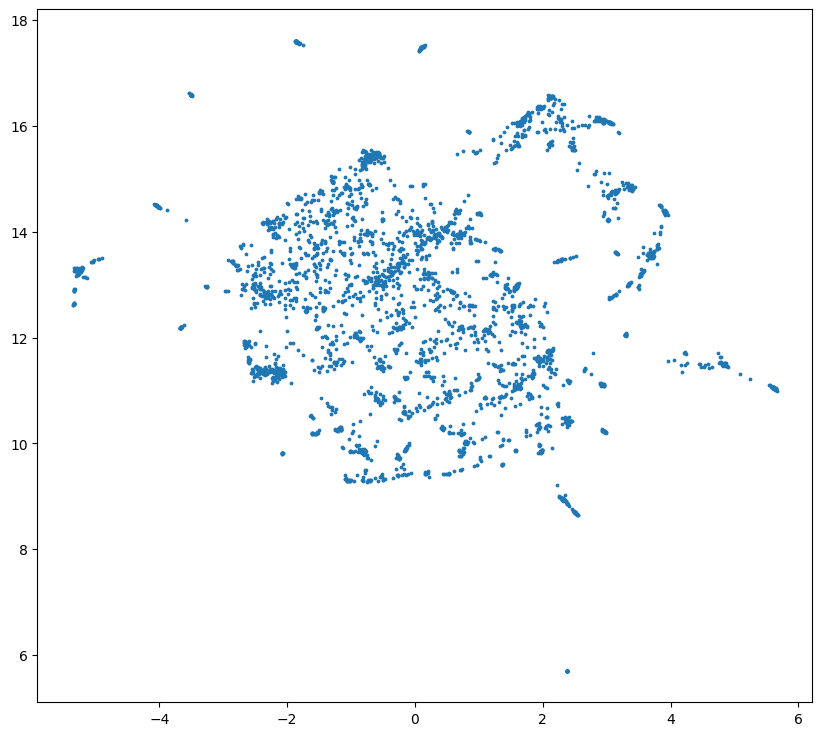

In [19]:
import umap

cluster_embedding = umap.UMAP(n_neighbors=30, min_dist=0.0,
                              n_components=2, random_state=42).fit_transform(X)

plt.figure(figsize=(10,9))
plt.scatter(cluster_embedding[:, 0], cluster_embedding[:, 1], s=3, cmap='Spectral')

In [20]:
products = train_df[["StockCode", "Description"]]

# remove duplicates
products.drop_duplicates(inplace=True, subset='StockCode', keep="last")

# create product-ID and product-description dictionary
products_dict = products.groupby('StockCode')['Description'].apply(list).to_dict()

In [21]:
# test the dictionary
products_dict['84029E']

['RED WOOLLY HOTTIE WHITE HEART.']

In [22]:
def similar_products(v, n = 6):
    
    # extract most similar products for the input vector
    ms = model.similar_by_vector(v, topn= n+1)[1:]
    
    # extract name and similarity score of the similar products
    new_ms = []
    for j in ms:
        pair = (products_dict[j[0]][0], j[1])
        new_ms.append(pair)
        
    return new_ms        

In [23]:
similar_products(model['90019A'])

[('SILVER M.O.P ORBIT DROP EARRINGS', 0.8197516798973083),
 ('BLUE MURANO TWIST BRACELET', 0.8042483329772949),
 ('FLOWER GLASS GARLD NECKL36"AMETHYST', 0.7795718312263489),
 ('PINK BOUDICCA LARGE BRACELET', 0.7762442827224731),
 ('AMBER DROP EARRINGS W LONG BEADS', 0.760036289691925),
 ('JADE DROP EARRINGS W FILIGREE', 0.7538443803787231)]

In [24]:

def aggregate_vectors(products):
    product_vec = []
    for i in products:
        try:
            product_vec.append(model[i])
        except KeyError:
            continue
        
    return np.mean(product_vec, axis=0)

In [25]:
len(purchases_val[0])

196

In [26]:
aggregate_vectors(purchases_val[0]).shape

(100,)

In [27]:
similar_products(aggregate_vectors(purchases_val[0]))

[('SET OF 3 CAKE TINS PANTRY DESIGN ', 0.6915759444236755),
 ('SET OF 3 REGENCY CAKE TINS', 0.6899055242538452),
 ('JAM MAKING SET WITH JARS', 0.6832338571548462),
 ('SPOTTY BUNTING', 0.6672874093055725),
 ('SET OF 6 SPICE TINS PANTRY DESIGN', 0.6645578145980835),
 ('REGENCY MILK JUG PINK ', 0.6634302139282227)]

In [28]:
similar_products(aggregate_vectors(purchases_val[0][-10:]))

[("PAPER CHAIN KIT 50'S CHRISTMAS ", 0.6307240724563599),
 ('PACK OF SIX LED TEA LIGHTS', 0.6274675130844116),
 ("BOX OF 6 MINI 50'S CRACKERS", 0.6180013418197632),
 ('VINTAGE ZINC PLANTER  ', 0.6175938844680786),
 ("BISCUIT TIN 50'S CHRISTMAS", 0.6157187223434448),
 ("3 RAFFIA RIBBONS 50'S CHRISTMAS ", 0.6129051446914673)]